In [1]:
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_30/donor0/"
donor = 0

param_names = ["pct_thresh","af_thresh", "other_pct_thresh"]
weights = [1,0,0,1,-1, 1, 1]

#anno_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
# pct_thresh = [0.01, 0.1, 0.25, 0.4, 0.5, 0.75, 0.95]
# other_pct_thresh = [0.01, 0.1, 0.25, 0.5]
# af_thresh = [0, 0.01, 0.1, 0.25, 0.4]

# Objective weights. order of the columns
# objectives_l = ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
#                 "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
#                 "pct_thresh","other_pct_thresh", "n_vars", "obj_nclones_more_than_one_unique"] #"nvars"
#     ncpus=8
#     topn=16

In [2]:
import src.clone_variants_optim  as optim
from mplh import cluster_help as ch
import mplh.cluster_help as ch
import mplh.fig_utils as fu

fig_utils from mplh


In [3]:
# from glob import glob
# glob(outdir + "/*csv")

In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, exists, dirname
from glob import glob
import pickle
from icecream import ic
ic.disable()
np.set_printoptions(formatter={'float': lambda x: format(x, '.3f')})
# matplotlib.rcParams['ps.useafm'] = False
# matplotlib.rcParams['pdf.use14corefonts'] = True
# matplotlib.rcParams['text.usetex'] = False

In [5]:

# objectives = {ind:x for ind,x in enumerate(objectives_l)}
# weights = np.array(weights)

# assert(len(weights)==len(objectives))
# objectives


# # In[9]:


# param_names = ["pct_thresh","af_thresh", "other_pct_thresh"]
# n_params = 3



# Load results

# top 10%

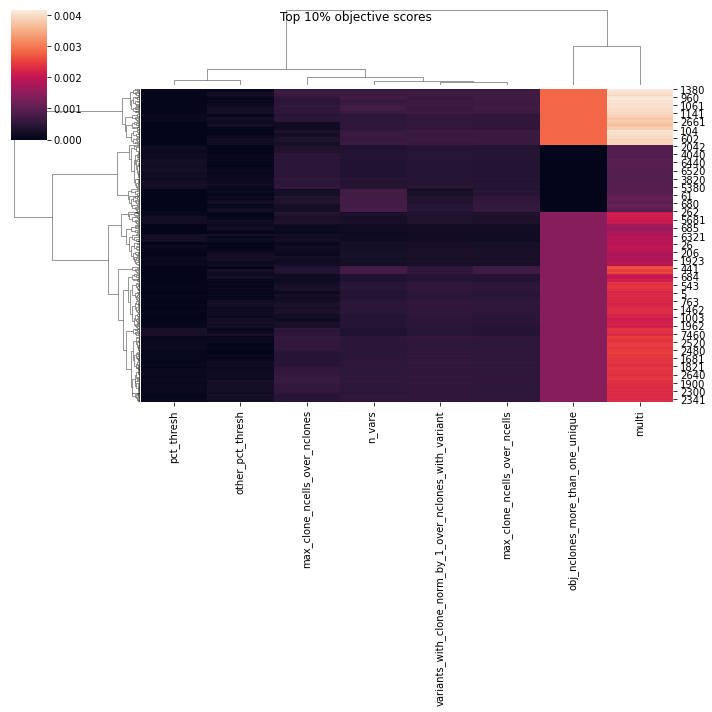

In [6]:
obj_norm_results = pd.read_csv(join(outdir, "objectives_norm.csv"), index_col=0)
obj_results = pd.read_csv(join(outdir, "objectives.csv"), index_col=0)
obj_results = pd.read_csv(join(outdir, "objectives_rank.csv"), index_col=0)
param_results = pd.read_csv(join(outdir, "params.csv"), index_col=0)

# top 10%
top10perc_n = int(obj_norm_results.shape[0]*0.1)
obj_norm_top10perc = obj_norm_results.iloc[:top10perc_n]
top10perc_n

param_results = param_results.loc[obj_norm_top10perc.index]
# obj_norm_top10perc_params = pd.merge(left=obj_norm_top10perc, right=param_results, left_index=True, right_index=True, how="left", 
#                                      suffixes=["_obj", ""])

g = sns.clustermap(obj_norm_top10perc)
g.fig.suptitle("Top 10% objective scores")
plt.savefig(join(outdir, "top10_objectives.png"))


## dynamic tree cut

In [7]:
from dynamicTreeCut import cutreeHybrid
from scipy.spatial.distance import pdist
import numpy as np
from scipy.cluster.hierarchy import linkage
#d = np.transpose(np.arange(1,10001).reshape(100,100))

distances = pdist(obj_norm_top10perc.drop("multi", axis=1).values, "euclidean")
link = linkage(distances, "average")
clusters = cutreeHybrid(link, distances)
# ..cutHeight not given, setting it to 495.1  ===>  99% of the (truncated) height range in dendro.
# ..done.
clusters["labels"]
clusters["ID"] = obj_norm_top10perc.index
clusters = pd.DataFrame({"ID":clusters["ID"], "labels": clusters["labels"]}, index=obj_norm_top10perc.index)#[["ID", "labels"]]

param_results = pd.merge(clusters, param_results, left_index=True, right_index=True, how="inner")

..cutHeight not given, setting it to 0.0018354335356670502  ===>  99% of the (truncated) height range in dendro.
..done.


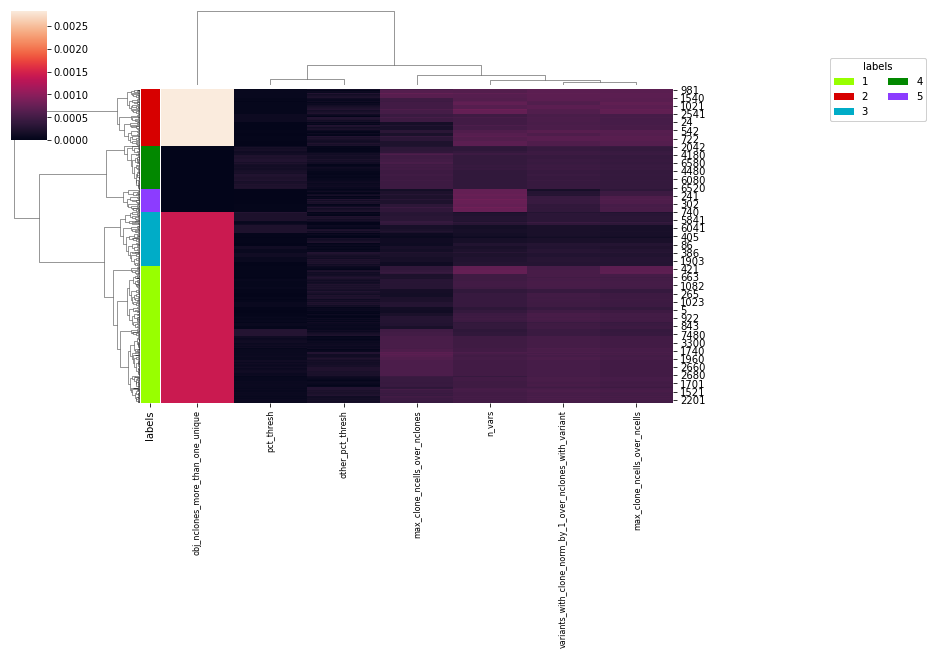

In [8]:
ch.plot_cluster(obj_norm_top10perc.drop("multi", axis=1), row_meta=clusters[["labels"]])
plt.savefig(join(outdir, "top_results_clusters.pdf"), dpi=300)

## Get average parameters for each cluster .  run unique over these

## Get the table for the average

In [9]:
af_indir = join(indir, "sc_af", f"donor{donor}")

AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")

cells_meta = pd.read_csv(join(indir, "cells_meta.tsv"), sep='\t', index_col="ID")#.sort_values(["donor", "lineage"])
cells_meta["name"] = cells_meta["donor"].astype(str)+"_"+cells_meta["lineage"].astype(str)
# if "donor_index" in cells_meta.columns and "lineage_index" in cells_meta.columns:
#     cells_meta = cells_meta.sort_values(["donor_index", "lineage_index"])
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
curr_labels = cells_meta[cells_meta["donor"]==donor]
curr_labels

conditions = curr_labels["condition"].unique()
conditions

def rm_high(df, thresh, pct_thresh):
    return df.loc[~(((df>thresh).sum(axis=1)>pct_thresh*df.shape[0]))]

def rm_low(df, thresh, pct_thresh):
    return df.loc[~((df<thresh).sum(axis=1)>(pct_thresh*df.shape[1]))]

    #return df.loc[~(((df<=thresh).sum(axis=1)>pct_thresh*df.shape[0]))]
#df[(df<0.01).sum(axis=1)]

## Get donor inds
donor_inds = AF_df.index[((AF_df>0.9).sum(axis=1)>(0.9*AF_df.shape[1]))]

AF_df.shape

(68, 9023)

In [10]:
top_params_mean_df = param_results.groupby("labels").mean().drop("ID", axis=1)
top_params_mean_df

,pct_thresh,other_pct_thresh,af_thresh
labels,,,
1,0.263522,0.511918,0.080472
2,0.149618,0.511870,0.084771
3,0.388492,0.460556,0.148254
4,0.686275,0.306961,0.014314
5,0.066981,0.456887,0.053113


## Create the clone-var table for the clustered params

In [11]:
all_df = []
all_objs = {}
for ind, val in top_params_mean_df.iterrows():
    print(ind)
    obj_out, data = optim.evaluate_series(val, AF_df, DP_df, curr_labels, return_data=True)
    all_df.append(data["all_unique_df"])
    all_objs[ind] = obj_out 
all_df = pd.concat(all_df)

results_df = pd.DataFrame(all_objs).transpose()
results_norm = optim.set_multi(results_df, weights)
rank_df = optim.set_multi_rank(results_norm, weights)

all_df["params"] = all_df.apply(optim.params_to_str, axis=1,
                                args=(param_names,))

## merge param and results
results_norm_params = pd.merge(left=top_params_mean_df, right=results_norm, right_index=True, left_index=True, suffixes=["", "_obj"])

results_norm_params["params"] = results_norm_params.apply(optim.params_to_str, axis=1,
                                args=(param_names,))
results_norm_params.index.name = "solution_cluster"
results_norm_params = results_norm_params.reset_index().set_index("params")

# sort by multi
results_norm_params = results_norm_params.sort_values(["multi"])[::-1]

results_norm_params

1
2
3
4
5
(5, 7)
objs_total variants_with_clone_norm_by_1_over_nclones_with_variant      57.186325
max_clone_ncells_over_nclones                              5936.368376
max_clone_ncells_over_ncells                                 65.663542
pct_thresh                                                    1.554888
other_pct_thresh                                              2.248192
dtype: float64


,solution_cluster,pct_thresh,other_pct_thresh,af_thresh,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh_obj,other_pct_thresh_obj,n_vars,obj_nclones_more_than_one_unique,multi
params,,,,,,,,,,,,
pct_thresh=0.264\naf_thresh=0.080\nother_pct_thresh=0.512\n,1,0.263522,0.511918,0.080472,0.263646,0.213281,0.241319,0.169480,0.227702,0.208791,0.666667,1.080881
pct_thresh=0.150\naf_thresh=0.085\nother_pct_thresh=0.512\n,2,0.149618,0.511870,0.084771,0.298619,0.226336,0.274871,0.096224,0.227681,0.241758,0.333333,0.742254
pct_thresh=0.686\naf_thresh=0.014\nother_pct_thresh=0.307\n,4,0.686275,0.306961,0.014314,0.209840,0.284770,0.190825,0.441366,0.136537,0.164835,0.000000,0.679505
pct_thresh=0.067\naf_thresh=0.053\nother_pct_thresh=0.457\n,5,0.066981,0.456887,0.053113,0.182833,0.209307,0.247983,0.043078,0.203224,0.340659,0.000000,0.363346
pct_thresh=0.388\naf_thresh=0.148\nother_pct_thresh=0.461\n,3,0.388492,0.460556,0.148254,0.045062,0.066306,0.045003,0.249852,0.204856,0.043956,0.000000,0.134014


## Add multi_obj and solution_cluster label to the table and to results

In [12]:
all_df["multi_obj"] = all_df.apply(lambda x: results_norm_params.loc[x["params"], "multi"], axis=1)
all_df["solution_cluster"] = all_df.apply(lambda x: results_norm_params.loc[x["params"], "solution_cluster"], axis=1)
all_df["params_multi"] = all_df.apply(optim.params_and_multi_str, axis=1)
clones_order, variants_order, heatmap_input = optim.prep_long_heatmap(all_df)
all_df["solution_params_obj"] = all_df.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
all_df

results_norm_params = results_norm_params.reset_index()
results_norm_params["multi_obj"] = results_norm_params["multi"]
results_norm_params["params_multi"] = results_norm_params.apply(optim.params_and_multi_str, axis=1)

results_norm_params["solution_params_obj"] = results_norm_params.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
results_norm_params

,params,solution_cluster,pct_thresh,other_pct_thresh,af_thresh,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh_obj,other_pct_thresh_obj,n_vars,obj_nclones_more_than_one_unique,multi,multi_obj,params_multi,solution_params_obj
0,pct_thresh=0.264\naf_thresh=0.080\nother_pct_t...,1,0.263522,0.511918,0.080472,0.263646,0.213281,0.241319,0.169480,0.227702,0.208791,0.666667,1.080881,1.080881,params:\npct_thresh=0.264\naf_thresh=0.080\not...,solution:1\n params:\npct_thresh=0.264\naf_thr...
1,pct_thresh=0.150\naf_thresh=0.085\nother_pct_t...,2,0.149618,0.511870,0.084771,0.298619,0.226336,0.274871,0.096224,0.227681,0.241758,0.333333,0.742254,0.742254,params:\npct_thresh=0.150\naf_thresh=0.085\not...,solution:2\n params:\npct_thresh=0.150\naf_thr...
2,pct_thresh=0.686\naf_thresh=0.014\nother_pct_t...,4,0.686275,0.306961,0.014314,0.209840,0.284770,0.190825,0.441366,0.136537,0.164835,0.000000,0.679505,0.679505,params:\npct_thresh=0.686\naf_thresh=0.014\not...,solution:4\n params:\npct_thresh=0.686\naf_thr...
3,pct_thresh=0.067\naf_thresh=0.053\nother_pct_t...,5,0.066981,0.456887,0.053113,0.182833,0.209307,0.247983,0.043078,0.203224,0.340659,0.000000,0.363346,0.363346,params:\npct_thresh=0.067\naf_thresh=0.053\not...,solution:5\n params:\npct_thresh=0.067\naf_thr...
4,pct_thresh=0.388\naf_thresh=0.148\nother_pct_t...,3,0.388492,0.460556,0.148254,0.045062,0.066306,0.045003,0.249852,0.204856,0.043956,0.000000,0.134014,0.134014,params:\npct_thresh=0.388\naf_thresh=0.148\not...,solution:3\n params:\npct_thresh=0.388\naf_thr...


## Plot cluster clone-var table

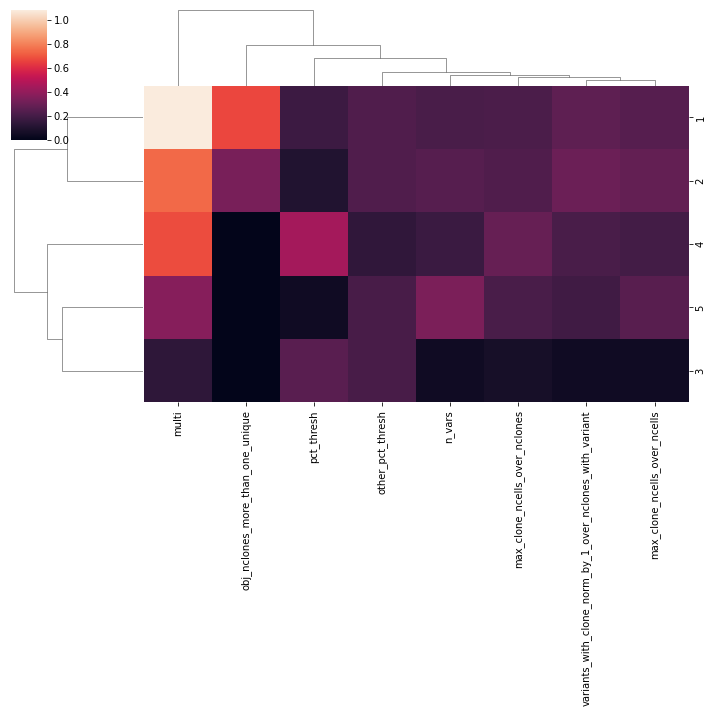

In [13]:
sns.clustermap(results_norm)
plt.savefig(join(outdir, "cluster_results.png"))
plt.savefig(join(outdir, "cluster_results.pdf"))

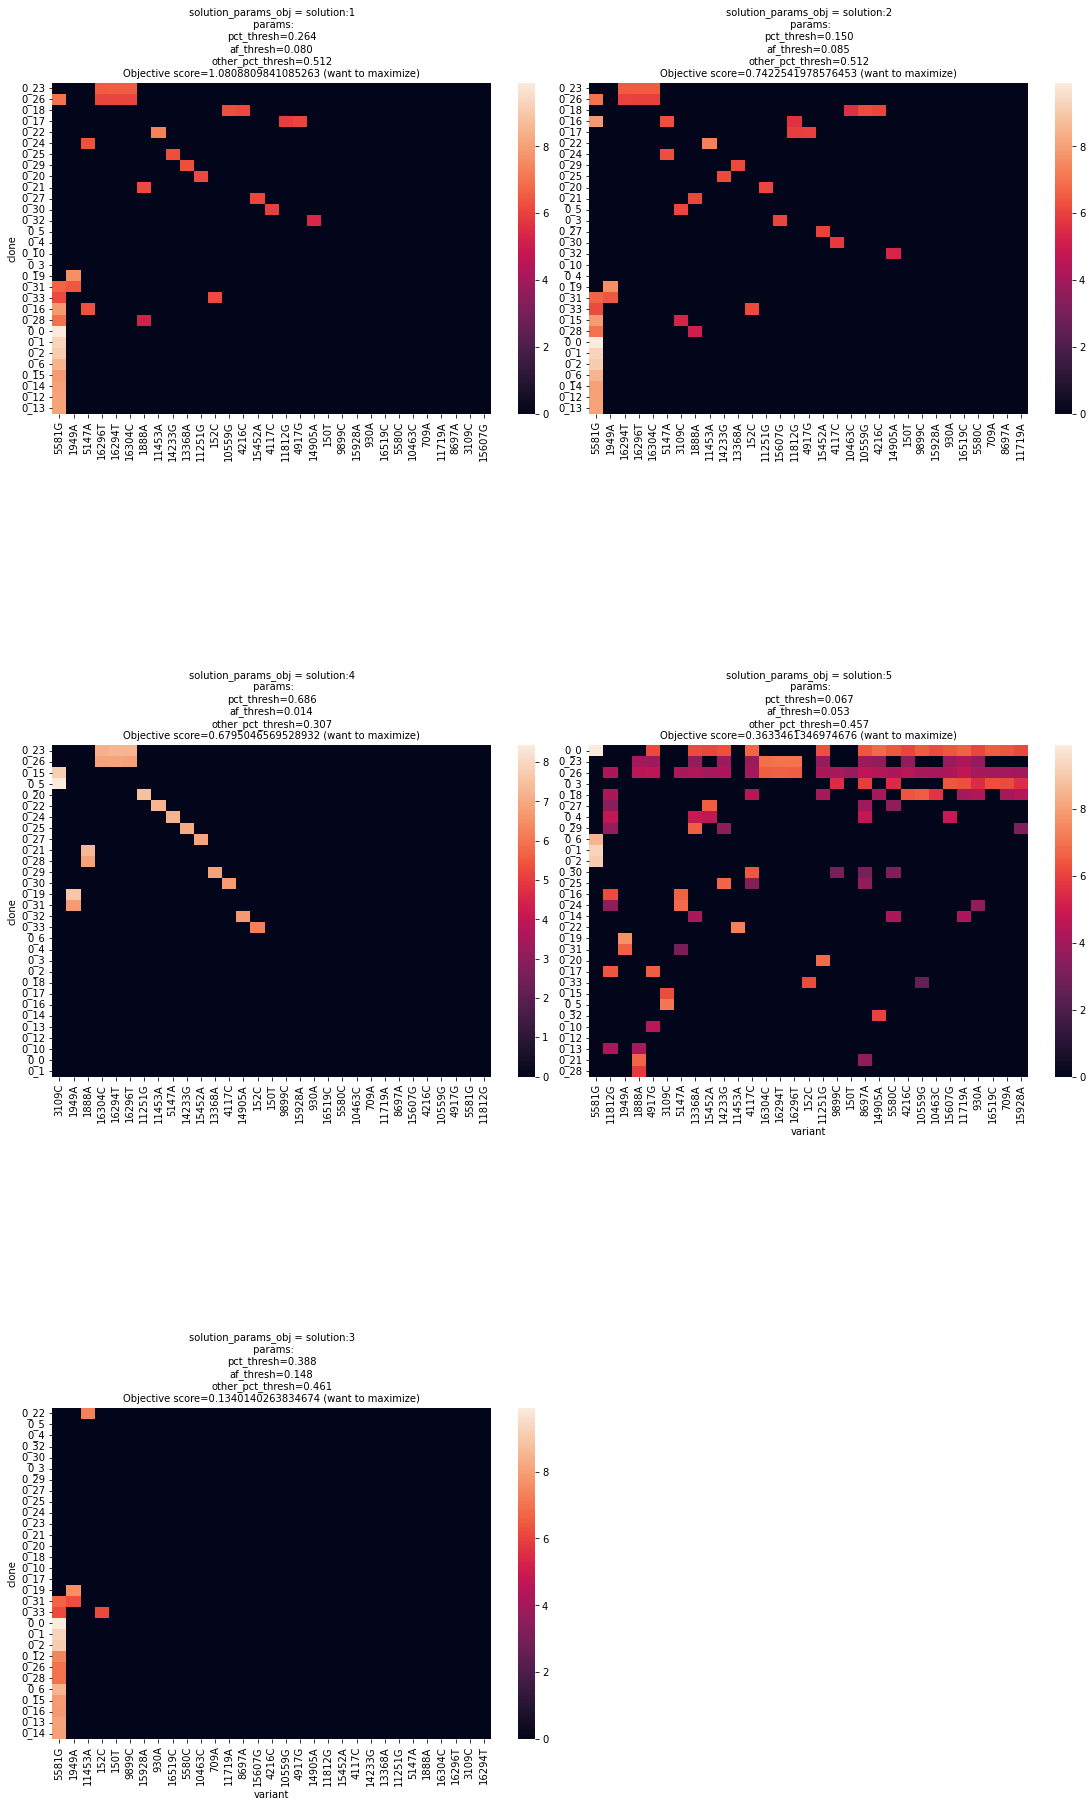

In [14]:
fg = sns.FacetGrid(data=all_df.reset_index(), height=4, aspect=2, sharey=False, sharex=False, 
                   col="solution_params_obj", col_wrap=2, 
                   col_order=results_norm_params["solution_params_obj"].values, margin_titles=False)

fg.map_dataframe(optim.draw_heatmap, 'variant','clone', 'log2_n_cells', 
                 clones_order=clones_order, 
                 variants_order=variants_order)#, cbar=False)
#fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
#fg.fig.suptitle(f"Best parameter combinations shown in order")
fg.fig.subplots_adjust(top=2, hspace = 1)

plt.savefig(join(outdir, "top_param_cluster_clone_vars.pdf"), dpi=300)

In [15]:
for ind, val in all_df.groupby("solution_params_obj"):
    print(ind)
    curr_dir = join(outdir, "best_params_clusters")
    if not exists(curr_dir):
        os.mkdir(curr_dir)
    curr_name = val["params"][0].replace("=", "__").replace("\n", "___").strip("_")
    curr_table = val.reset_index().pivot(index="clone",columns="variant",values="n_cells").fillna(0).astype(int)
    curr_table.to_csv(join(curr_dir, f"clone_variants.{curr_name}.csv"))

solution:1
 params:
pct_thresh=0.264
af_thresh=0.080
other_pct_thresh=0.512
Objective score=1.0808809841085263 (want to maximize)
solution:2
 params:
pct_thresh=0.150
af_thresh=0.085
other_pct_thresh=0.512
Objective score=0.7422541978576453 (want to maximize)
solution:3
 params:
pct_thresh=0.388
af_thresh=0.148
other_pct_thresh=0.461
Objective score=0.1340140263834674 (want to maximize)
solution:4
 params:
pct_thresh=0.686
af_thresh=0.014
other_pct_thresh=0.307
Objective score=0.6795046569528932 (want to maximize)
solution:5
 params:
pct_thresh=0.067
af_thresh=0.053
other_pct_thresh=0.457
Objective score=0.3633461346974676 (want to maximize)
